# ch6. decision tree
이제 데이터를 통해서 생존 여부를 예측하는 모델을 만들어 보겠습니다. 이전 챕터에서 생존 여부에 영향을 많이 끼치는 요소들에 대해서 알아보았습니다. 주요 요인으로는 성별, 지불한 금액, 좌석 등급 등이 있었습니다. 이렇게 예측에 사용할 수 있는 데이터의 종류가 여러가지일 때, 사용하면 좋은 기법으로 의사 결정 나무, decision tree가 있습니다.

decision tree는 스무 고개 놀이와 비슷하다고 생각하시면 됩니다. 

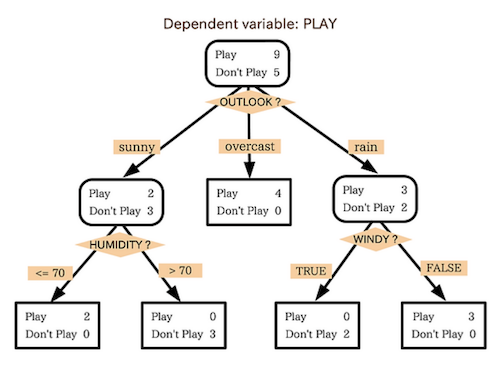

위 예시는 운동경기가 열렸다면 PLAY=1, 그렇지 않으면 PLAY=0으로 하는 이진분류 문제입니다. 날씨가 맑고(sunny), 습도(humidity)가 70 이하인 날엔 경기가 열렸습니다. 해당 조건에 맞는 데이터들이 ‘경기가 열렸다(play 2건)’고 말하고 있기 때문입니다. 반대로 비가 오고(rain) 바람이 부는(windy) 날엔 경기가 열리지 않았습니다. 의사결정나무를 일반화한 그림은 아래와 같습니다.

의사 결정 나무를 타이타닉호 생존자 예측 문제에도 비슷하게 대입할 수 있습니다. 먼저 성별을 묻고, 그 다음 지불한 금액을 묻는 식으로 트리를 만들 수 있습니다. 한번 트리를 만들고 나면, 새로운 사람의 데이터에 대해서도 생존 여부를 예측할 수 있게 됩니다.

decision tree 알고리즘은 학습용 데이터 셋에 가장 잘 들어맞는 의사 결정 나무를 만들어줍니다. 이미 구현된 알고리즘을 가져다 쓰는 건 쉽습니다만, 그 전에 기본 개념을 숙지하고 사용하면 훨씬 자유롭게 사용할 수 있으니, 꼭 이해하고 넘어갔으면 좋겠습니다.

## 불순도 / 불확실성

의사 결정 나무는 한번 분기를 칠 때마다 변수 영역을 두개로 구분합니다. 그리고 각 영역의 불순도가 최대한 감소하는 방향으로 분기를 칩니다.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

data = [
    (1, 5, "red"), (2, 4, "red"),  (3, 2.5, "red"),  (4, 3, "red"), (4, 5, "red"),  (5, 4, "red"),  
    (6, 5.5, "red"),  (6, 2, "red"),  (8, 4, "red"), (9, 4, "red"), (1, 2, "blue"),  (2, 1.5, "blue"),  
    (4.5, 1.5, "blue"), (5, 3, "blue"),  (7, 3, "blue"),  (9, 5.5, "blue")
]

(0.0, 6.0)

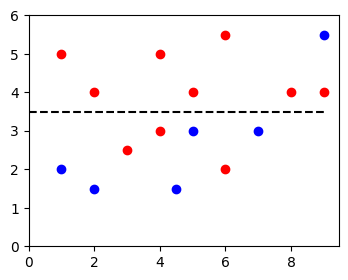

In [2]:
plt.figure(figsize=(4, 3))
plt.scatter(
    [x[0] for x in data if x[-1] == "red"],
    [x[1] for x in data if x[-1] == "red"],
    color="red"
)
plt.scatter(
    [x[0] for x in data if x[-1] == "blue"],
    [x[1] for x in data if x[-1] == "blue"],
    color="blue"
)
plt.plot(np.arange(0, 10), np.full((10), 3.5), "--", color="black")
plt.xlim(xmin=0)
plt.ylim(ymin=0, ymax=6)

빨간 점과 파란 점을 분류하는 모델을 만든다고 생각해보겠습니다. 이 때, 분류를 위해서 우리가 사용할 수 있는 데이터는 점들의 x값과 y값입니다. 불순도를 최소화하는 방향으로 영역을 분리하려면 먼저 불순도를 계산하는 방법을 알아야 합니다.  

## Entrophy
불순도를 계산하는 방법 중에 엔트로피가 있습니다. 본래는 열역학에서 무질서도를 의미하는 용어이지만, 통계학이나 머신러닝 분야에서도 많이 사용되는 개념입니다.

$$Entrophy(A)=-\sum_{k=1}^{m}p_{k}log_{2}{p_{k}}$$

여기서 m은 범주의 개수입니다. 즉, 각 범주에 대해서 특정 범주가 등장할 확률과 그 음의 로그 값을 곱한 값의 총 합을 계산하는 것입니다. 위 예시에 대해서 계산 한번 해보겠습니다. 먼저 영역을 분리하기 전에는 빨간 점 10개와 파란점 6개가 하나의 영역에 섞여있습니다.

$$Entropy(A)=-\frac{10}{16}log_{2}{\frac{10}{16}}\;-\frac{6}{16}log_{2}{\frac{6}{16}}\approx 0.95$$

In [3]:
from math import log2

def calculate_entrophy(data):
    red_dots = [x for x in data if x[-1] == "red"]
    blue_dots = [x for x in data if x[-1] == "blue"]
    p_red = len(red_dots) / len(data)
    p_blue = len(blue_dots) / len(data)
    entrophy = -1 * ((p_red * log2(p_red)) + (p_blue * log2(p_blue)))
    return entrophy

In [4]:
calculate_entrophy(data)

0.954434002924965

검은색 점선을 기준으로 데이터의 영역을 구분하여 영역별 엔트로피를 구한 다음, 가중 평균을 내보겠습니다. 여기서 d는 영역의 개수, Ri는 각 영역별 비중입니다.

$$Entropy(A)=\sum_{i=1}^{d}R_{i}(-\sum_{k=1}^{m}p_{k}log_{2}{p_{k}})$$

$$Entropy(A)=0.5*(-\frac{7}{8}log_{2}{\frac{7}{8}}\;-\frac{1}{8}log_{2}{\frac{1}{8}})\;+\;0.5*(-\frac{3}{8}log_{2}{\frac{3}{8}}\;-\frac{5}{8}log_{2}{\frac{5}{8}})\approx 0.75$$

In [5]:
split_a = [x for x in data if x[1] > 3.5]
split_b = [x for x in data if x[1] <= 3.5]

In [6]:
ratio_a = len(split_a) / len(data)
ratio_b = len(split_b) / len(data)

In [7]:
ratio_a, ratio_b

(0.5, 0.5)

In [8]:
entrophy_a = calculate_entrophy(split_a)
entrophy_b = calculate_entrophy(split_b)

In [9]:
total_entrophy = ratio_a * entrophy_a + ratio_b * entrophy_b

In [10]:
total_entrophy

0.7489992230622807

영역을 구분지어서 점들을 나누니 각 영역별 불순도가 줄어들었고, 이를 합친 전체 불순도도 줄어드는 것이 보이시나요? 의사 결정 나무는 이런 분기 치는 과정을 재귀적으로 수행하면서 처음에 봤었던 나무 형태의 모델을 만드는 알고리즘 입니다.

엔프로피 외에도 지니계수, 카이제곱 통계량 등 불순도를 계산할 수 있는 지수들이 몇 가지 더 있습니다만, 의사결정 나무의 동작 원리를 이해하는 것이 목적이므로 여기까지 알아보도록 하겠습니다.

## 의사 결정 나무 모델 학습 과정
의사 결정 나무 모델은 크게 재귀적 분기와 가지치기 과정으로 나뉩니다. 

### 재귀적 분기
의사결정나무의 학습 과정은 입력 변수 영역을 두 개로 구분하는 재귀적 분기(recursive partitioning)와 너무 자세하게 구분된 영역을 통합하는 가지치기(pruning) 두 가지 과정으로 나뉩니다. 우선 재귀적 분기 먼저 살펴보겠습니다. 예시로 income과 lot size를 독립변수, ownership을 종속변수로 갖는 데이터 셋을 하나 가져왔습니다.

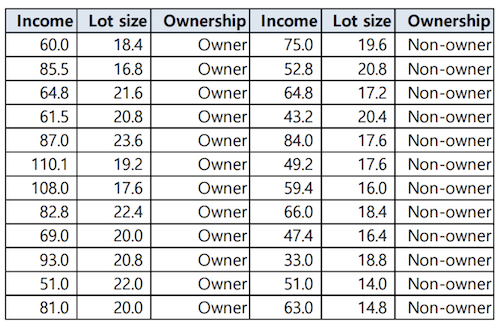

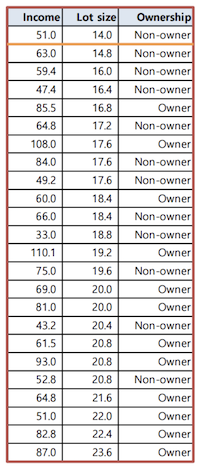

재귀적 가지치기 작업은 먼저 컬럼을 하나 선택한 후에 해당 컬럼으로 데이터들을 정렬합니다. 그 다음, 분기를 칠 수 있는 모든 지점에 대해서 이전 불순도와 이후 불순도를 계산합니다. 특정 컬럼에 대해서 모두 계산하였다면 다음 컬럼으로 데이터를 정렬하고, 불순도 계산합니다. 이 과정을 반복하여 불순도를 가장 많이 줄일 수 있는 최적의 분기를 찾습니다.

### 가지치기
의사결정나무 모델 학습의 또다른 축은 가지치기(pruning)입니다. 모든 leaf node의 순도가 100%인 상태를 Full tree라고 하는데요. 이렇게 Full tree를 생성한 뒤 적절한 수준에서 terminal node를 결합해주어야 합니다. 왜냐하면 분기가 너무 많아서 학습데이터에 과적합(overfitting)할 염려가 생기기 때문입니다. 즉, 분기가 너무 적으면 모델의 설명력이 떨어지고, 분기가 너무 많으면 과적합이 발생하니, 이를 가지치기를 통해서 적절히 균형을 맞춰줘야 합니다.

가지치기에도 다양한 방법들이 있지만, 너무 복잡하므로 생략하겠습니다. 여기서는 학습 데이터를 모두 설명할 수 있을 때까지 재귀적으로 분기를 만들고, 이를 적절히 컷팅하여 사용하는 것이 decision tree라는 것까지 이해하고 넘어가겠습니다.

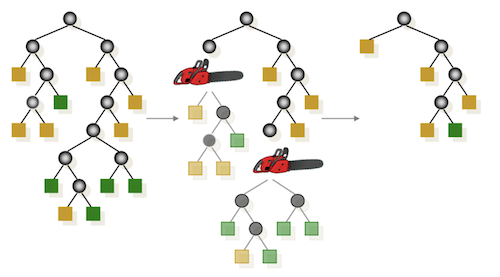

## 정리
이번 챕터에서는 정말 정말 많이 사용되는 decision tree의 기본 동작 원리에 대해서 배워봤습니다. 이 decision tree를 기반으로 한 random forest나 gradient boosting 개념이 적용된 XGboost, CatBoost, lightGBM은 실제 kaggle 대회나 현업에서도 많이 사용되니, 기본 개념을 확실하게 숙지하고 넘어가면 좋겠습니다.